In [1]:
import os
import yaml
import urllib
from PIL import Image
from enum import Enum
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

import xml.etree.cElementTree as ET
import glob
import argparse
import numpy as np
import json
import numpy
import cv2
from collections import OrderedDict
import scipy.misc
from skimage import measure   
from shapely.geometry import Polygon, MultiPolygon, MultiPoint
import random
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import shutil
import pickle
import pandas as pd

WORKING_DIRECTORY = '/media/dean/datastore/datasets/darknet_evaluate'
COCO_DIRECTORY = os.path.join(WORKING_DIRECTORY, 'data', 'coco')
BDD10K_COCO_ANNOTATIONS_FILE = os.path.join(COCO_DIRECTORY,'annotations' , 'bdd10k_instances_val2014.json')
IMAGES_DIRECTORY = os.path.join(COCO_DIRECTORY, 'images','train2014')
WEIGHTS_DIRECTORY = os.path.join(WORKING_DIRECTORY,'trained_weights')
LABELS_DIRECTORY = os.path.join(COCO_DIRECTORY, 'labels','train2014')
CATEGORY_NAMES = os.path.join(WORKING_DIRECTORY, 'data', 'coco.bdd100k.names')

In [2]:
bdd10k_coco = COCO(BDD10K_COCO_ANNOTATIONS_FILE)
ann_ids = bdd10k_coco.getAnnIds()
print(len(ann_ids))

loading annotations into memory...
Done (t=2.00s)
creating index...
index created!
185578


In [3]:
# For Run in Training Runs    
training_runs = os.listdir(os.path.join(WEIGHTS_DIRECTORY,'training_runs'))
all_runs = []
#for run in [training_runs[1]]:
for run in training_runs:
    print('Evaluating mAP on Training Run:', os.path.join(WEIGHTS_DIRECTORY,'training_runs',run))
    # Grab iterations and sort checkpoints
    d = {}
    weights_files = glob.glob(os.path.join(WEIGHTS_DIRECTORY,'training_runs',run, '*.weights'))
    
    for fpath in weights_files:
        fname = os.path.split(fpath)[-1]
        iterations = fname[15:].split('.weights')[0]
        if iterations != 'final':
            d[fname] = int(iterations)
        else:
            d[fname] = 100000
    sorted_weights = OrderedDict(sorted(d.items(), key=lambda kv: kv[1]))
    bdd_weights = OrderedDict()

    for weights_file in sorted_weights.keys():
        d = {}
        d['iterations'] = sorted_weights[weights_file]
        d['map_results_file'] = os.path.join(WEIGHTS_DIRECTORY, 'training_runs',run, weights_file+'.txt')
        map_results_file = d['map_results_file']
        d['map_results_file'] = d['map_results_file'] +'.backup'

        if not os.path.exists(d['map_results_file']):
            # Create annotations if labels directory not found
            if not os.path.exists(os.path.join(COCO_DIRECTORY,'labels/train2014/manifast.txt')):
                #!java -jar $WORKING_DIRECTORY/data/cocotoyolo.jar "{BDD10K_COCO_ANNOTATIONS_FILE}" "{IMAGES_DIRECTORY}/" "all" "{COCO_DIRECTORY}/labels/train2014"
                yolo_convert_output = os.path.join(COCO_DIRECTORY, 'labels','convert2yolo_results.txt')
                !python3 $WORKING_DIRECTORY/convert2Yolo/example.py --datasets COCO --img_path "{IMAGES_DIRECTORY}" --label "{BDD10K_COCO_ANNOTATIONS_FILE}" --convert_output_path "{LABELS_DIRECTORY}" --img_type ".jpg" --manipast_path $LABELS_DIRECTORY --cls_list_file $CATEGORY_NAMES | tee -a $yolo_convert_output
                
            CURRENT_WEIGHT = os.path.join(WEIGHTS_DIRECTORY, 'training_runs',run, weights_file)
            outfile = !cd $WORKING_DIRECTORY && ./darknet detector map cfg/bdd100k.data cfg/yolov3-bdd100k.cfg $CURRENT_WEIGHT | tee -a $map_results_file
            with open(d['map_results_file'],"w+") as f:
                outfile = '\n'.join(outfile)
                f.write(outfile)

        #Get mAP results from file
        class_stats = []
        map_stats = {}
        with open(d['map_results_file']) as openfile:
            for line in openfile:
                for part in line.split():
                    if 'class_id' in part:
                        class_map = {}
                        if 'class_id =' in line:
                            id_tokens = line.split('class_id =')[1].split(',')
                            if id_tokens[0] in [str(i) for i in range(10)]: 
                                class_map['class_id'] = int(id_tokens[0].strip())
                        
                        if 'name =' in line:
                            name_tokens = line.split('name =')[1].split(',')
                            class_map['class_name'] = name_tokens[0].strip()

                        if 'ap =' in line:
                            ap_tokens = line.split('ap =')[1].split(',')
                            class_map['class_ap'] = ap_tokens[0].split('%')[0].strip()

                        class_stats.append(class_map)
                    elif '(mAP)' in part:
                        tokens = line.split('(mAP) =')[1]
                        map_stats['mean_avg_precision'] = tokens.split()[2].strip(',')
                    elif 'Detection' in part:
                        tokens = line.split(':')[1]
                        total_detection_time = str(''.join(tokens)).strip()
                        map_stats['total_detection_time'] = total_detection_time
        map_stats['weights'] = d
        map_stats['class_stats'] = class_stats
        print(map_stats,'\n\n') 
        bdd_weights[weights_file] = map_stats

    # Make sure Dictionary is made properly
    all_runs.append((run, bdd_weights))

# Cache Data    
pickle_file = os.path.join(COCO_DIRECTORY, 'mAP_all_runs.pickle')
pickle_dict = {'all_runs': all_runs}
with open(pickle_file,"wb") as pickle_out:
    pickle.dump(pickle_dict, pickle_out)   

Evaluating mAP on Training Run: /media/dean/datastore/datasets/darknet_evaluate/trained_weights/training_runs/run2_oldanchors
{'total_detection_time': '296.000000 Seconds', 'mean_avg_precision': '3.02', 'weights': {'iterations': 1094, 'map_results_file': '/media/dean/datastore/datasets/darknet_evaluate/trained_weights/training_runs/run2_oldanchors/yolov3-bdd100k_1094.weights.txt.backup'}, 'class_stats': [{'class_name': 'person', 'class_ap': '9.18'}, {'class_name': 'rider', 'class_ap': '0.02'}, {'class_name': 'car', 'class_ap': '13.60'}, {'class_name': 'truck', 'class_ap': '1.34'}, {'class_name': 'bus', 'class_ap': '1.82'}, {'class_name': 'train', 'class_ap': '0.00'}, {'class_name': 'motor', 'class_ap': '0.02'}, {'class_name': 'bike', 'class_ap': '0.01'}, {'class_name': 'traffic sign', 'class_ap': '0.09'}, {'class_name': 'traffic light', 'class_ap': '4.13'}]} 


{'total_detection_time': '301.000000 Seconds', 'mean_avg_precision': '2.37', 'weights': {'iterations': 2188, 'map_results_file

{'total_detection_time': '300.000000 Seconds', 'mean_avg_precision': '17.96', 'weights': {'iterations': 14222, 'map_results_file': '/media/dean/datastore/datasets/darknet_evaluate/trained_weights/training_runs/run2_oldanchors/yolov3-bdd100k_14222.weights.txt.backup'}, 'class_stats': [{'class_name': 'person', 'class_ap': '18.96'}, {'class_name': 'rider', 'class_ap': '12.22'}, {'class_name': 'car', 'class_ap': '31.72'}, {'class_name': 'truck', 'class_ap': '32.60'}, {'class_name': 'bus', 'class_ap': '28.61'}, {'class_name': 'train', 'class_ap': '0.00'}, {'class_name': 'motor', 'class_ap': '13.15'}, {'class_name': 'bike', 'class_ap': '14.47'}, {'class_name': 'traffic sign', 'class_ap': '19.29'}, {'class_name': 'traffic light', 'class_ap': '8.55'}]} 


{'total_detection_time': '304.000000 Seconds', 'mean_avg_precision': '16.37', 'weights': {'iterations': 15316, 'map_results_file': '/media/dean/datastore/datasets/darknet_evaluate/trained_weights/training_runs/run2_oldanchors/yolov3-bdd100k_1

{'total_detection_time': '307.000000 Seconds', 'mean_avg_precision': '18.73', 'weights': {'iterations': 25162, 'map_results_file': '/media/dean/datastore/datasets/darknet_evaluate/trained_weights/training_runs/run2_oldanchors/yolov3-bdd100k_25162.weights.txt.backup'}, 'class_stats': [{'class_name': 'person', 'class_ap': '18.82'}, {'class_name': 'rider', 'class_ap': '19.41'}, {'class_name': 'car', 'class_ap': '31.32'}, {'class_name': 'truck', 'class_ap': '34.83'}, {'class_name': 'bus', 'class_ap': '33.20'}, {'class_name': 'train', 'class_ap': '0.00'}, {'class_name': 'motor', 'class_ap': '15.25'}, {'class_name': 'bike', 'class_ap': '18.13'}, {'class_name': 'traffic sign', 'class_ap': '12.44'}, {'class_name': 'traffic light', 'class_ap': '3.90'}]} 


{'total_detection_time': '301.000000 Seconds', 'mean_avg_precision': '19.81', 'weights': {'iterations': 26256, 'map_results_file': '/media/dean/datastore/datasets/darknet_evaluate/trained_weights/training_runs/run2_oldanchors/yolov3-bdd100k_2

{'total_detection_time': '303.000000 Seconds', 'mean_avg_precision': '19.86', 'weights': {'iterations': 38290, 'map_results_file': '/media/dean/datastore/datasets/darknet_evaluate/trained_weights/training_runs/run2_oldanchors/yolov3-bdd100k_38290.weights.txt.backup'}, 'class_stats': [{'class_name': 'person', 'class_ap': '20.94'}, {'class_name': 'rider', 'class_ap': '21.44'}, {'class_name': 'car', 'class_ap': '30.65'}, {'class_name': 'truck', 'class_ap': '36.71'}, {'class_name': 'bus', 'class_ap': '36.80'}, {'class_name': 'train', 'class_ap': '0.00'}, {'class_name': 'motor', 'class_ap': '19.04'}, {'class_name': 'bike', 'class_ap': '17.70'}, {'class_name': 'traffic sign', 'class_ap': '11.10'}, {'class_name': 'traffic light', 'class_ap': '4.27'}]} 


{'total_detection_time': '302.000000 Seconds', 'mean_avg_precision': '21.49', 'weights': {'iterations': 39384, 'map_results_file': '/media/dean/datastore/datasets/darknet_evaluate/trained_weights/training_runs/run2_oldanchors/yolov3-bdd100k_3

{'total_detection_time': '648.000000 Seconds', 'mean_avg_precision': '21.95', 'weights': {'iterations': 49230, 'map_results_file': '/media/dean/datastore/datasets/darknet_evaluate/trained_weights/training_runs/run2_oldanchors/yolov3-bdd100k_49230.weights.txt.backup'}, 'class_stats': [{'class_name': 'person', 'class_ap': '21.56'}, {'class_name': 'rider', 'class_ap': '23.28'}, {'class_name': 'car', 'class_ap': '32.30'}, {'class_name': 'truck', 'class_ap': '37.62'}, {'class_name': 'bus', 'class_ap': '38.77'}, {'class_name': 'train', 'class_ap': '0.00'}, {'class_name': 'motor', 'class_ap': '19.93'}, {'class_name': 'bike', 'class_ap': '20.10'}, {'class_name': 'traffic sign', 'class_ap': '16.83'}, {'class_name': 'traffic light', 'class_ap': '9.14'}]} 


{'total_detection_time': '297.000000 Seconds', 'mean_avg_precision': '22.23', 'weights': {'iterations': 50324, 'map_results_file': '/media/dean/datastore/datasets/darknet_evaluate/trained_weights/training_runs/run2_oldanchors/yolov3-bdd100k_5

{'total_detection_time': '307.000000 Seconds', 'mean_avg_precision': '29.69', 'weights': {'iterations': 14222, 'map_results_file': '/media/dean/datastore/datasets/darknet_evaluate/trained_weights/training_runs/run1_newanchors/yolov3-bdd100k_14222.weights.txt.backup'}, 'class_stats': [{'class_name': 'person', 'class_ap': '28.97'}, {'class_name': 'rider', 'class_ap': '23.75'}, {'class_name': 'car', 'class_ap': '56.60'}, {'class_name': 'truck', 'class_ap': '44.53'}, {'class_name': 'bus', 'class_ap': '40.02'}, {'class_name': 'train', 'class_ap': '0.00'}, {'class_name': 'motor', 'class_ap': '14.43'}, {'class_name': 'bike', 'class_ap': '22.79'}, {'class_name': 'traffic sign', 'class_ap': '42.03'}, {'class_name': 'traffic light', 'class_ap': '23.76'}]} 


{'total_detection_time': '281.000000 Seconds', 'mean_avg_precision': '33.85', 'weights': {'iterations': 15316, 'map_results_file': '/media/dean/datastore/datasets/darknet_evaluate/trained_weights/training_runs/run1_newanchors/yolov3-bdd100k_

{'total_detection_time': '277.000000 Seconds', 'mean_avg_precision': '35.48', 'weights': {'iterations': 26256, 'map_results_file': '/media/dean/datastore/datasets/darknet_evaluate/trained_weights/training_runs/run1_newanchors/yolov3-bdd100k_26256.weights.txt.backup'}, 'class_stats': [{'class_name': 'person', 'class_ap': '35.33'}, {'class_name': 'rider', 'class_ap': '29.32'}, {'class_name': 'car', 'class_ap': '61.66'}, {'class_name': 'truck', 'class_ap': '48.78'}, {'class_name': 'bus', 'class_ap': '48.16'}, {'class_name': 'train', 'class_ap': '0.00'}, {'class_name': 'motor', 'class_ap': '21.04'}, {'class_name': 'bike', 'class_ap': '28.43'}, {'class_name': 'traffic sign', 'class_ap': '50.25'}, {'class_name': 'traffic light', 'class_ap': '31.84'}]} 


{'total_detection_time': '273.000000 Seconds', 'mean_avg_precision': '36.62', 'weights': {'iterations': 27350, 'map_results_file': '/media/dean/datastore/datasets/darknet_evaluate/trained_weights/training_runs/run1_newanchors/yolov3-bdd100k_

{'total_detection_time': '295.000000 Seconds', 'mean_avg_precision': '40.43', 'weights': {'iterations': 42666, 'map_results_file': '/media/dean/datastore/datasets/darknet_evaluate/trained_weights/training_runs/run1_newanchors/yolov3-bdd100k_42666.weights.txt.backup'}, 'class_stats': [{'class_name': 'person', 'class_ap': '40.81'}, {'class_name': 'rider', 'class_ap': '31.78'}, {'class_name': 'car', 'class_ap': '65.22'}, {'class_name': 'truck', 'class_ap': '54.25'}, {'class_name': 'bus', 'class_ap': '53.32'}, {'class_name': 'train', 'class_ap': '0.00'}, {'class_name': 'motor', 'class_ap': '28.83'}, {'class_name': 'bike', 'class_ap': '30.31'}, {'class_name': 'traffic sign', 'class_ap': '56.53'}, {'class_name': 'traffic light', 'class_ap': '43.21'}]} 


{'total_detection_time': '427.000000 Seconds', 'mean_avg_precision': '40.40', 'weights': {'iterations': 43760, 'map_results_file': '/media/dean/datastore/datasets/darknet_evaluate/trained_weights/training_runs/run1_newanchors/yolov3-bdd100k_

{'total_detection_time': '297.000000 Seconds', 'mean_avg_precision': '42.07', 'weights': {'iterations': 54700, 'map_results_file': '/media/dean/datastore/datasets/darknet_evaluate/trained_weights/training_runs/run1_newanchors/yolov3-bdd100k_54700.weights.txt.backup'}, 'class_stats': [{'class_name': 'person', 'class_ap': '42.33'}, {'class_name': 'rider', 'class_ap': '33.64'}, {'class_name': 'car', 'class_ap': '65.34'}, {'class_name': 'truck', 'class_ap': '55.12'}, {'class_name': 'bus', 'class_ap': '54.42'}, {'class_name': 'train', 'class_ap': '0.00'}, {'class_name': 'motor', 'class_ap': '33.39'}, {'class_name': 'bike', 'class_ap': '34.48'}, {'class_name': 'traffic sign', 'class_ap': '57.26'}, {'class_name': 'traffic light', 'class_ap': '44.73'}]} 


{'total_detection_time': '299.000000 Seconds', 'mean_avg_precision': '41.48', 'weights': {'iterations': 55794, 'map_results_file': '/media/dean/datastore/datasets/darknet_evaluate/trained_weights/training_runs/run1_newanchors/yolov3-bdd100k_

In [4]:
print(len(bdd_weights))

56


## Plot Metrics


In [5]:
bdd_data = []
for run, bdd_weights in [all_runs[0]]:
    for weights, map_stats in bdd_weights.items():
        d = {}
        d['training_run'] = run
        d['map_results_file'] = map_stats['weights']['map_results_file']
        d['iterations'] = map_stats['weights']['iterations']
        d['mean_avg_precision'] = map_stats['mean_avg_precision']
        d['person_ap'], d['rider_ap'], d['car_ap'], d['truck_ap'], d['bus_ap'], d['train_ap'], d['motor_ap'], d['bike_ap'], d['traffic_sign_ap'], d['traffic_light_ap'] = [0.0]*10
        
                    
        for cls in map_stats['class_stats']:
            cls_name = cls.get('class_name', '').strip()
            if cls_name == 'person':
                d['person_ap'] = cls['class_ap']
            elif cls_name == 'rider':
                d['rider_ap'] = cls['class_ap']
            elif cls_name == 'car':
                d['car_ap'] = cls['class_ap']
            elif cls_name == 'truck':
                d['truck_ap'] = cls['class_ap']
            elif cls_name == 'bus':
                d['bus_ap'] = cls['class_ap']
            elif cls_name == 'train':
                d['train_ap'] = cls['class_ap']
            elif cls_name == 'motor':
                d['motor_ap'] = cls['class_ap']
            elif cls_name == 'bike':
                d['bike_ap'] = cls['class_ap']
            elif cls_name == 'traffic sign':
                d['traffic_sign_ap'] = cls['class_ap']
            elif cls_name == 'traffic light':
                d['traffic_light_ap'] = cls['class_ap']
        d['total_detection_time'] = map_stats['total_detection_time']
        bdd_data.append(d)
data = pd.DataFrame(bdd_data)
data = data.apply(pd.to_numeric, errors='ignore')
data.head(100)

,bike_ap,bus_ap,car_ap,iterations,map_results_file,mean_avg_precision,motor_ap,person_ap,rider_ap,total_detection_time,traffic_light_ap,traffic_sign_ap,train_ap,training_run,truck_ap
0,0.01,1.82,13.60,1094,/media/dean/datastore/datasets/darknet_evaluat...,3.02,0.02,9.18,0.02,296.000000 Seconds,4.13,0.09,0.0,run2_oldanchors,1.34
1,0.00,3.03,16.06,2188,/media/dean/datastore/datasets/darknet_evaluat...,2.37,0.00,2.55,1.14,301.000000 Seconds,0.49,0.00,0.0,run2_oldanchors,0.47
2,0.00,3.03,22.55,3282,/media/dean/datastore/datasets/darknet_evaluat...,4.76,0.22,5.33,1.61,299.000000 Seconds,14.74,0.00,0.0,run2_oldanchors,0.16
3,0.00,4.55,27.36,4376,/media/dean/datastore/datasets/darknet_evaluat...,5.07,0.00,9.60,3.26,260.000000 Seconds,5.75,0.00,0.0,run2_oldanchors,0.17
4,2.46,13.95,35.63,5470,/media/dean/datastore/datasets/darknet_evaluat...,13.76,9.09,9.67,2.63,299.000000 Seconds,21.43,22.32,0.0,run2_oldanchors,20.42
5,4.51,18.62,33.48,6564,/media/dean/datastore/datasets/darknet_evaluat...,14.97,3.82,16.79,4.02,259.000000 Seconds,21.96,22.33,0.0,run2_oldanchors,24.20
6,7.62,21.27,31.61,7658,/media/dean/datastore/datasets/darknet_evaluat...,15.20,3.74,17.56,7.67,258.000000 Seconds,16.82,18.31,0.0,run2_oldanchors,27.40
7,12.70,22.16,39.89,8752,/media/dean/datastore/datasets/darknet_evaluat...,19.27,5.43,17.97,8.07,259.000000 Seconds,24.83,32.88,0.0,run2_oldanchors,28.79
8,12.36,24.41,29.25,9846,/media/dean/datastore/datasets/darknet_evaluat...,14.02,7.62,13.18,12.07,258.000000 Seconds,1.36,9.07,0.0,run2_oldanchors,30.85
9,14.40,25.09,37.84,10940,/media/dean/datastore/datasets/darknet_evaluat...,19.31,8.02,18.27,11.07,263.000000 Seconds,20.24,28.87,0.0,run2_oldanchors,29.33


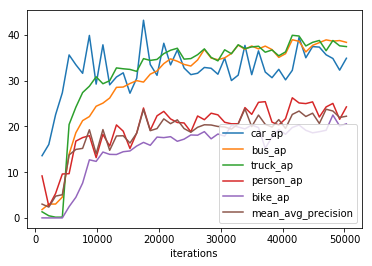

In [6]:
%matplotlib inline 
data.plot(x='iterations',y=['car_ap', 'bus_ap', 'truck_ap', 'person_ap', 'bike_ap', 'mean_avg_precision'])
plt.rcParams['figure.figsize'] = [128.0, 180.0]
plt.show()

In [7]:
import os

class_stats = []
map_stats = {}
class_map = {}
with open("/Users/deanwebb/Desktop/yolov3-bdd100k_28416.weights.txt.backup", 'r') as openfile:
    line = next(openfile)
    while line:
        reg_match = RegExParser(line)

        if reg_match.class_id:
            class_map['class_id'] = reg_match.class_id.group(1)

        if reg_match.class_name:
            class_map['class_name'] = reg_match.class_name.group(1)

        if reg_match.class_ap:
            class_map['class_ap'] = reg_match.class_ap.group(1)

        if reg_match.mean_ap:
            map_stats['mean_avg_precision'] = reg_match.mean_ap.group(1)

        if reg_match.obj_thresh:
            map_stats['obj_thresh'] = reg_match.obj_thresh.group(1)

        if reg_match.precision:
            map_stats['precision'] = reg_match.precision.group(1)

        if reg_match.recall:
            map_stats['recall'] = reg_match.recall.group(1)

        if reg_match.f1:
            map_stats['f1_score'] = reg_match.f1.group(1)

        if reg_match.TP:
            map_stats['TP'] = reg_match.TP.group(1)

        if reg_match.FP:
            map_stats['FP'] = reg_match.FP.group(1)

        if reg_match.FN:
            map_stats['FN'] = reg_match.FN.group(1)

        if reg_match.avg_IoU:
            map_stats['avg_IoU'] = reg_match.avg_IoU.group(1)




    #Get mAP results from file
    for line in openfile:
        for part in line.split():
            if 'class_id' in part:
                class_map = {}
                id_tokens = line.split('class_id =')[1].split(',')
                class_map['class_id'] = int(id_tokens[0].strip())

                    name_tokens = line.split('name =')[1].split(',')
                class_map['class_name'] = name_tokens[0]

                if 'ap =' in line:
                    ap_tokens = line.split('ap =')[1].split(',')
                    class_map['class_ap'] = ap_tokens[0].split('%')[0].strip()

                class_stats.append(class_map)
            elif '(mAP)' in part:
                tokens = line.split('(mAP) =')[1]
                map_stats['mean_avg_precision'] = tokens.split()[2].strip(',')
            elif 'Detection' in part:
                tokens = line.split(':')[1]
                total_detection_time = str(''.join(tokens)).strip()
                map_stats['total_detection_time'] = total_detection_time
    map_stats['class_stats'] = class_stats
print(map_stats,'\n\n')


with open(filepath, 'r') as file:
    line = next(file)
    while line:
        reg_match = _RegExLib(line)

        if reg_match.school:
            school = reg_match.school.group(1)

        if reg_match.grade:
            grade = reg_match.grade.group(1)
            grade = int(grade)

        if reg_match.name_score:
            value_type = reg_match.name_score.group(1)
            line = next(file, None)
            while line and line.strip():
                number, value = line.strip().split(',')
                value = value.strip()
                dict_of_data = {
                    'School': school,
                    'Grade': grade,
                    'Student number': number,
                    value_type: value
                }
                data.append(dict_of_data)
                line = next(file, None)

        line = next(file, None)

IndentationError: unexpected indent (<ipython-input-7-e016061f8afa>, line 58)